In [1]:
%cd ..

/Users/robin/Documents/Projects/soc-rag/src


/Users/robin/Documents/Projects/soc-rag/.venv/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
from benchmark import BenchmarkResult, BenchmarkResultSet
from pandas import DataFrame
from scipy.stats import friedmanchisquare
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

In [3]:
LINEWIDTH = 0.75
PALETTE = "pastel"
sns.set_theme(style="whitegrid", font="Nimbus Roman", palette=PALETTE, rc={
    "font.size": 8,
    "axes.titlesize": 8,
    "axes.labelsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "legend.title_fontsize": 8,
    "legend.fontsize": 5,
    "lines.linewidth": LINEWIDTH,
    "patch.linewidth": 0.4,
    "hatch.linewidth": 0.1,
    "boxplot.flierprops.linewidth": LINEWIDTH,
    "boxplot.flierprops.markeredgewidth": LINEWIDTH,
    "boxplot.boxprops.linewidth": LINEWIDTH,
    "boxplot.whiskerprops.linewidth": LINEWIDTH,
    "boxplot.capprops.linewidth": LINEWIDTH,
    "boxplot.medianprops.linewidth": LINEWIDTH,
    "boxplot.meanprops.linewidth": LINEWIDTH,
})
FIGSIZE_SINGLE = (3.5, 2)
FIGSIZE_DOUBLE = (7.16, 2)
RESULTS_DIRECTORY = "analysis/diagrams"

In [4]:
def initialize_plot(figsize):
    figure, axis = plt.subplots(figsize=figsize, dpi=300)
    plt.tight_layout()
    return axis

def finalize_plot(axis, filename):
    sns.move_legend(axis, "center left", bbox_to_anchor=(1, 0.5), frameon=False)
    sns.despine(left=True, bottom=True)
    plt.savefig(os.path.join(RESULTS_DIRECTORY, f"{filename}.pdf"), bbox_inches="tight", pad_inches=0)

In [5]:
def rename_model(model: str) -> str:
    if model == "bge_small":
        return "BGE"
    if model == "nvidia":
        return "NVIDIA"
    if model == "oai":
        return "OpenAI"
    return model

def rename_chunking_strategy(strategy: str) -> str:
    if strategy == "endpoint_split_1024_0":
        return "Endpoint Split (0)"
    if strategy == "endpoint_split_1024_20":
        return "Endpoint Split (20)"
    if strategy == "endpoint_split_thin":
        return "Endpoint Split Thin"
    if strategy == "endpoint_split_field":
        return "Endpoint Split Field"
    if strategy == "endpoint_json":
        return "Endpoint Split JSON"
    if strategy == "query_extraction":
        return "Query"
    if strategy == "summary":
        return "Summary"
    if strategy == "craft":
        return "CRAFT"
    if strategy == "whole_document_100_0":
        return "Whole Document (100, 0)"
    if strategy == "whole_document_100_20":
        return "Whole Document (100, 20)"
    if strategy == "whole_document_200_0":
        return "Whole Document (200, 0)"
    if strategy == "whole_document_200_20":
        return "Whole Document (200, 20)"
    if strategy == "json_100_0":
        return "JSON (100, 0)"
    if strategy == "json_100_20":
        return "JSON (100, 20)"
    if strategy == "agent":
        return "Agent"
    return strategy

In [6]:
DOMAIN = "Domain"
BENCHMARK = "Benchmark"
RECALL = "Recall"
PRECISION = "Precision"
MODEL = "Model"
CHUNKING_STRATEGY = "Chunking Strategy"
TOKEN = "Token"
TOKEN_COMPLETION = "Token Completion"
TOKEN_PROMPT = "Token Prompt"
TOKEN_RESPONSE = "Token Response"
K = "K"
NUMBER_OF_BENCHMARKS = 5
MODELS = ["bge_small", "nvidia", "oai"]
MODELS_FORMATED = [rename_model(model) for model in MODELS]
KS = ["5", "10", "20"]
CHUNKING_STRATEGIES = [
    # "whole_document_1024_0",
    # "whole_document_2048_0",
    # "whole_document_4096_0",
    # "whole_document_8191_0",
    # "whole_document_1024_50",
    # "whole_document_2048_50",
    # "whole_document_4096_50",
    # "whole_document_8191_50",
    "endpoint_split_1024_0",
    # "endpoint_split_2048_0",
    # "endpoint_split_4096_0",
    # "endpoint_split_8191_0",
    # "endpoint_split_1024_50",
    "endpoint_split_1024_20",
    # "endpoint_split_2048_50",
    # "endpoint_split_4096_50",
    # "endpoint_split_8191_50",
    "endpoint_split_thin",
    "endpoint_split_field",
    # "json_1024_0",
    # "json_2048_0",
    # "json_4096_0",
    # "json_8191_0",
    # "json_1024_50",
    # "json_2048_50",
    # "json_4096_50",
    # "json_8191_50",
    "endpoint_json",
    "query_extraction",
    "summary",
    "craft",
]
CHUNKING_STRATEGIES_FORMATED = [rename_chunking_strategy(strategy) for strategy in CHUNKING_STRATEGIES]

In [7]:
def merge_benchmark_results(results: list[BenchmarkResultSet], chunking_strategy: str, model: str, k: str, precise_token: bool = False) -> DataFrame:
    assert len(results) > 0
    assert chunking_strategy
    assert len(chunking_strategy) > 0
    assert model
    assert len(model) > 0
    if precise_token:
        data = [[result.name, rename_model(model), rename_chunking_strategy(chunking_strategy), benchmark_result.name.title(), k, entry.recall, entry.precision, entry.token.completion_token, entry.token.prompt_token, entry.token.response_token] for result in results for benchmark_result in result.results for entry in benchmark_result.entries]
        return DataFrame(data, columns=[BENCHMARK, MODEL, CHUNKING_STRATEGY, DOMAIN, K, RECALL, PRECISION, TOKEN_COMPLETION, TOKEN_PROMPT, TOKEN_RESPONSE])
    else:
        data = [[result.name, rename_model(model), rename_chunking_strategy(chunking_strategy), benchmark_result.name.title(), k, entry.recall, entry.precision, entry.token] for result in results for benchmark_result in result.results for entry in benchmark_result.entries]
        return DataFrame(data, columns=[BENCHMARK, MODEL, CHUNKING_STRATEGY, DOMAIN, K, RECALL, PRECISION, TOKEN])

In [8]:
def load_results(model: str, k: str, chunking_strategy: str, precise_token: bool = False) -> DataFrame:
    result_files = [open(f'../data/socbenchd_{i+1}/{model}/{chunking_strategy}/results_{k}.json').read() for i in range(NUMBER_OF_BENCHMARKS)]
    results = [BenchmarkResultSet.model_validate_json(result_file) for result_file in result_files]
    return merge_benchmark_results(results, chunking_strategy, model, k, precise_token)
results = [load_results(model, k, chunking_strategy) for model in MODELS for k in KS for chunking_strategy in CHUNKING_STRATEGIES]
dataframe = pd.concat(results)

In [9]:
dataframe

,Benchmark,Model,Chunking Strategy,Domain,K,Recall,Precision,Token
0,socbenchd_1,BGE,Endpoint Split (0),Energy,5,0.200000,0.200000,691
1,socbenchd_1,BGE,Endpoint Split (0),Energy,5,0.400000,0.400000,895
2,socbenchd_1,BGE,Endpoint Split (0),Energy,5,0.375000,0.600000,883
3,socbenchd_1,BGE,Endpoint Split (0),Energy,5,0.666667,0.400000,811
4,socbenchd_1,BGE,Endpoint Split (0),Energy,5,0.800000,0.800000,873
...,...,...,...,...,...,...,...,...
545,socbenchd_5,OpenAI,CRAFT,Real Estate,20,1.000000,0.200000,3296
546,socbenchd_5,OpenAI,CRAFT,Real Estate,20,0.714286,0.250000,2993
547,socbenchd_5,OpenAI,CRAFT,Real Estate,20,0.500000,0.150000,3133
548,socbenchd_5,OpenAI,CRAFT,Real Estate,20,0.666667,0.100000,3116


In [10]:
grouped = dataframe.groupby([MODEL, CHUNKING_STRATEGY, K], as_index=False).mean(numeric_only=True)

In [11]:
grouped

,Model,Chunking Strategy,K,Recall,Precision,Token
0,BGE,CRAFT,10,0.643635,0.269759,1585.801818
1,BGE,CRAFT,20,0.823333,0.181765,3137.510909
2,BGE,CRAFT,5,0.467071,0.367182,794.109091
3,BGE,Endpoint Split (0),10,0.653039,0.273269,1560.809091
4,BGE,Endpoint Split (0),20,0.835388,0.184668,3109.649091
...,...,...,...,...,...,...
67,OpenAI,Query,20,0.827698,0.182909,3073.283636
68,OpenAI,Query,5,0.476690,0.374364,782.040000
69,OpenAI,Summary,10,0.664109,0.280940,1561.474545
70,OpenAI,Summary,20,0.836668,0.185513,3092.003636


In [12]:
grouped.sort_values(by=RECALL, ascending=False)

,Model,Chunking Strategy,K,Recall,Precision,Token
46,NVIDIA,Summary,20,0.898774,0.202554,3112.460000
37,NVIDIA,Endpoint Split JSON,20,0.893004,0.200261,2589.883636
31,NVIDIA,Endpoint Split (20),20,0.889032,0.198899,3047.643636
28,NVIDIA,Endpoint Split (0),20,0.889032,0.198899,3047.643636
40,NVIDIA,Endpoint Split Thin,20,0.883316,0.197663,2381.005455
...,...,...,...,...,...,...
68,OpenAI,Query,5,0.476690,0.374364,782.040000
2,BGE,CRAFT,5,0.467071,0.367182,794.109091
23,BGE,Summary,5,0.452017,0.358485,866.983636
20,BGE,Query,5,0.446326,0.349545,778.940000


In [13]:
pd.set_option('display.max_rows', 100)

In [14]:
grouped["Recall/Token"] = grouped[RECALL] / grouped[TOKEN]
grouped["F1"] = 2 * grouped[PRECISION] * grouped[RECALL] / (grouped[PRECISION] + grouped[RECALL])

In [15]:
grouped.sort_values(by=[RECALL, "Recall/Token"], ascending=False).head(100)

,Model,Chunking Strategy,K,Recall,Precision,Token,Recall/Token,F1
46,NVIDIA,Summary,20,0.898774,0.202554,3112.460000,0.000289,0.330601
37,NVIDIA,Endpoint Split JSON,20,0.893004,0.200261,2589.883636,0.000345,0.327156
28,NVIDIA,Endpoint Split (0),20,0.889032,0.198899,3047.643636,0.000292,0.325071
31,NVIDIA,Endpoint Split (20),20,0.889032,0.198899,3047.643636,0.000292,0.325071
40,NVIDIA,Endpoint Split Thin,20,0.883316,0.197663,2381.005455,0.000371,0.323038
25,NVIDIA,CRAFT,20,0.874577,0.195422,3099.814545,0.000282,0.319461
61,OpenAI,Endpoint Split JSON,20,0.864215,0.192030,2639.121818,0.000327,0.314237
34,NVIDIA,Endpoint Split Field,20,0.863562,0.192225,3036.649091,0.000284,0.314454
64,OpenAI,Endpoint Split Thin,20,0.859441,0.190995,2453.087273,0.000350,0.312535
55,OpenAI,Endpoint Split (20),20,0.857248,0.190371,3070.318182,0.000279,0.311554


In [16]:
grouped.sort_values(by=[PRECISION], ascending=False).head(100)

,Model,Chunking Strategy,K,Recall,Precision,Token,Recall/Token,F1
47,NVIDIA,Summary,5,0.552962,0.446515,796.430909,0.000694,0.494070
38,NVIDIA,Endpoint Split JSON,5,0.543788,0.437818,661.365455,0.000822,0.485083
29,NVIDIA,Endpoint Split (0),5,0.534483,0.430788,773.349091,0.000691,0.477066
32,NVIDIA,Endpoint Split (20),5,0.534483,0.430788,773.349091,0.000691,0.477066
41,NVIDIA,Endpoint Split Thin,5,0.529323,0.426364,600.809091,0.000881,0.472297
35,NVIDIA,Endpoint Split Field,5,0.519302,0.422061,765.565455,0.000678,0.465659
62,OpenAI,Endpoint Split JSON,5,0.518327,0.415939,695.090909,0.000746,0.461523
56,OpenAI,Endpoint Split (20),5,0.517474,0.414364,788.174545,0.000657,0.460214
53,OpenAI,Endpoint Split (0),5,0.517053,0.413727,788.310909,0.000656,0.459655
65,OpenAI,Endpoint Split Thin,5,0.517756,0.413091,623.967273,0.000830,0.459539


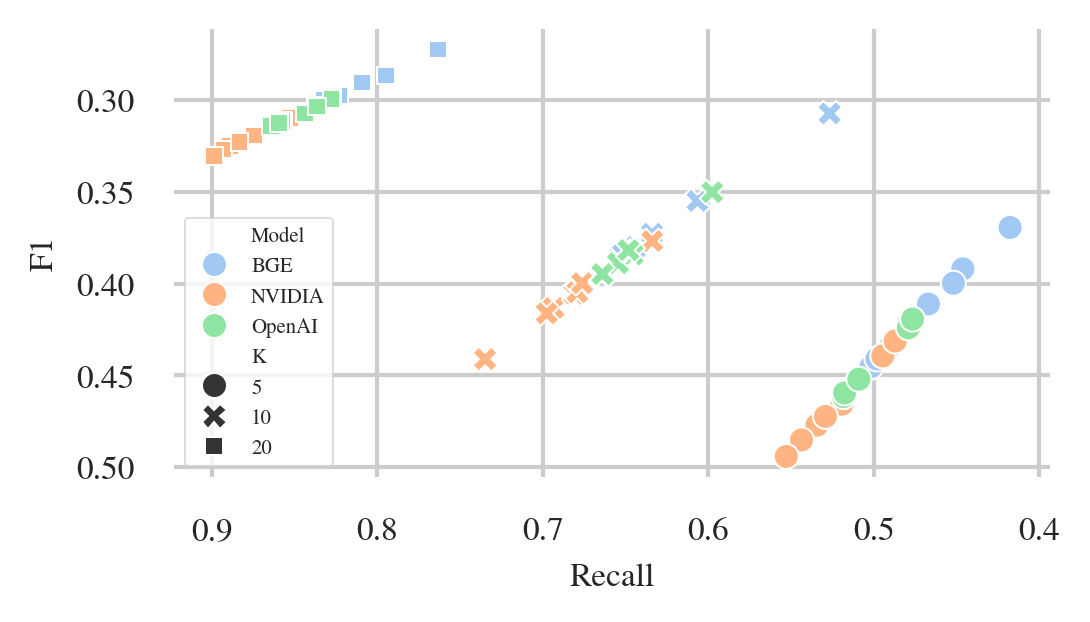

In [17]:
axis = initialize_plot(FIGSIZE_SINGLE)
axis.invert_xaxis()
axis.invert_yaxis()
sns.despine(left=True, bottom=True)
sns.scatterplot(x=RECALL, y="F1", hue=MODEL, style=K, style_order=KS, data=grouped, ax=axis)
def label_point(x, y, val, axis):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        axis.text(point['x']+.02, point['y'], str(point['val']))
# plt.savefig(os.path.join(RESULTS_DIRECTORY, f"cross-domain_average.pdf"), bbox_inches="tight", pad_inches=0)
# label_point(grouped[RECALL], grouped["F1"], grouped[CHUNKING_STRATEGY], ax)

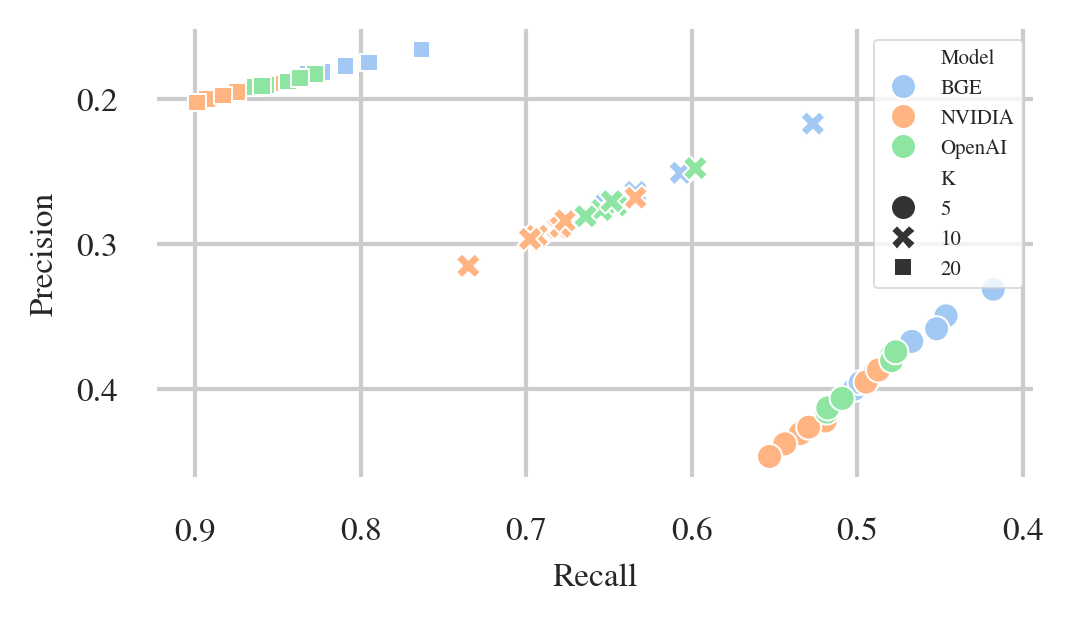

In [18]:
axis = initialize_plot(FIGSIZE_SINGLE)
axis.invert_xaxis()
axis.invert_yaxis()
sns.despine(left=True, bottom=True)
sns.scatterplot(x=RECALL, y=PRECISION, hue=MODEL, style=K, style_order=KS, data=grouped, ax=axis)
plt.savefig(os.path.join(RESULTS_DIRECTORY, f"cross-domain_average.pdf"), bbox_inches="tight", pad_inches=0)
# label_point(grouped[RECALL], grouped["F1"], grouped[CHUNKING_STRATEGY], ax)

In [19]:
COUNT = 10
precision = grouped.sort_values(by=[PRECISION], ascending=False).head(COUNT)
recall = grouped.sort_values(by=[RECALL], ascending=False).head(COUNT)
f1 = grouped.sort_values(by=["F1"], ascending=False).head(COUNT)
index = 1

for (row_precision, row_recall) in zip(precision.itertuples(), recall.itertuples()):
    line = f"{index}. & {row_recall[1]} & {row_recall[2]} & {row_recall[3]} & {row_precision[1]} & {row_precision[2]} & {row_precision[3]} \\\\"
    line = line.replace("Endpoint Split", "ES")
    line = line.replace("NVIDIA", "NV")
    line = line.replace("OpenAI", "OAI")
    print(line)
    index += 1

1. & NV & Summary & 20 & NV & Summary & 5 \\
2. & NV & ES JSON & 20 & NV & ES JSON & 5 \\
3. & NV & ES (20) & 20 & NV & ES (0) & 5 \\
4. & NV & ES (0) & 20 & NV & ES (20) & 5 \\
5. & NV & ES Thin & 20 & NV & ES Thin & 5 \\
6. & NV & CRAFT & 20 & NV & ES Field & 5 \\
7. & OAI & ES JSON & 20 & OAI & ES JSON & 5 \\
8. & NV & ES Field & 20 & OAI & ES (20) & 5 \\
9. & OAI & ES Thin & 20 & OAI & ES (0) & 5 \\
10. & OAI & ES (20) & 20 & OAI & ES Thin & 5 \\


In [20]:
def draw_violine(data: DataFrame, x: str, y: str, filename: str, hue=None, hue_order=None, figsize=FIGSIZE_DOUBLE, split=False):
    axis = initialize_plot(figsize)
    sns.violinplot(data, x=x, y=y, hue=hue, hue_order=hue_order, ax=axis, split=split)
    finalize_plot(axis, filename)
def draw_violine_swarm(data: DataFrame, x: str, y: str, filename: str, hue=None, hue_order=None, figsize=FIGSIZE_DOUBLE):
    axis = initialize_plot(figsize)
    sns.violinplot(data, x=x, y=y, hue=hue, hue_order=hue_order, ax=axis, inner=None)
    sns.move_legend(axis, "lower right")
    sns.swarmplot(data=data, size=1, x=x, y=y, hue=hue, hue_order=hue_order, ax=axis, dodge=True, legend=False, palette='dark:k')
    sns.despine(left=True, bottom=True)
    finalize_plot(axis, filename)
def draw_box(data: DataFrame, x: str, y: str, filename: str, hue=None, order=None, hue_order=None, figsize=FIGSIZE_DOUBLE):
    axis = initialize_plot(figsize)
    sns.boxplot(data, x=x, y=y, hue=hue, hue_order=hue_order, ax=axis, order=order)
    axis.set_xticks(axis.get_xticks())
    axis.set_xticklabels(axis.get_xticklabels(), fontsize=6)
    finalize_plot(axis, filename)

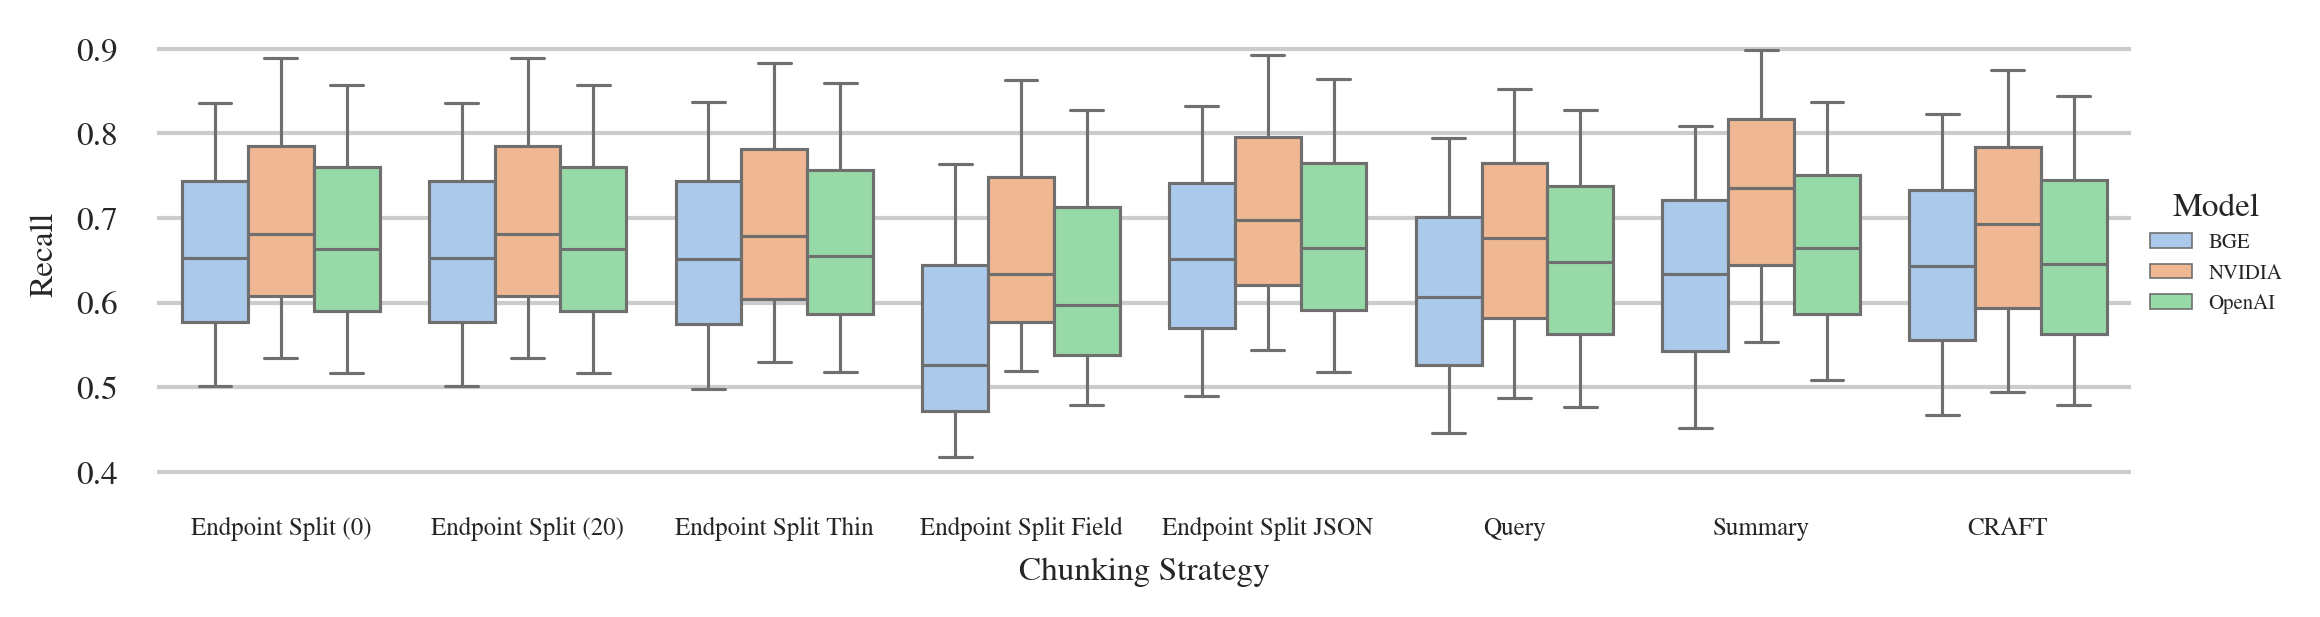

In [21]:
draw_box(data=grouped, x=CHUNKING_STRATEGY, order=CHUNKING_STRATEGIES_FORMATED, y=RECALL, hue=MODEL, filename="recall_model_chunking_strategy")

In [22]:
with_domains = dataframe.groupby([MODEL, CHUNKING_STRATEGY, K, DOMAIN], as_index=False).mean(numeric_only=True)

<Axes: xlabel='Chunking Strategy', ylabel='Domain'>

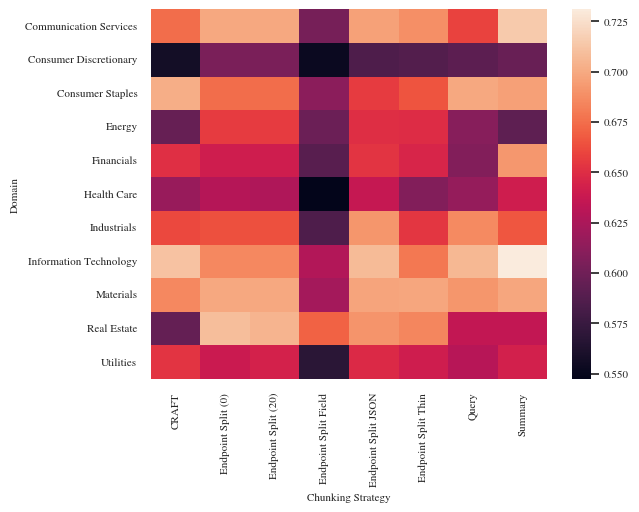

In [23]:
filtered = with_domains[(with_domains[MODEL] == "OpenAI") & (with_domains[K] == "10")]
sns.heatmap(filtered.pivot_table(index=DOMAIN, columns=CHUNKING_STRATEGY, values=RECALL), annot=False, fmt=".2f")

In [24]:
with_domains

,Model,Chunking Strategy,K,Domain,Recall,Precision,Token
0,BGE,CRAFT,10,Communication Services,0.671603,0.296000,1610.40
1,BGE,CRAFT,10,Consumer Discretionary,0.588151,0.257667,1534.50
2,BGE,CRAFT,10,Consumer Staples,0.690840,0.296944,1438.48
3,BGE,CRAFT,10,Energy,0.644619,0.264000,1633.48
4,BGE,CRAFT,10,Financials,0.615619,0.246000,1684.40
...,...,...,...,...,...,...,...
787,OpenAI,Summary,5,Industrials,0.504476,0.410000,871.82
788,OpenAI,Summary,5,Information Technology,0.567273,0.434333,730.54
789,OpenAI,Summary,5,Materials,0.530048,0.386000,745.02
790,OpenAI,Summary,5,Real Estate,0.457952,0.390000,824.70


In [25]:
def cv(x):
    """coefficient of variation"""
    return x.std() / x.mean()

In [26]:
stability_by_domain = dataframe.groupby(by=[MODEL,CHUNKING_STRATEGY,K,DOMAIN])[RECALL].agg(["mean", "std", cv])
stability_by_domain = stability_by_domain.sort_values(by="mean", ascending=False)
stability_by_domain.reset_index()

,Model,Chunking Strategy,K,Domain,mean,std,cv
0,NVIDIA,Summary,20,Communication Services,0.958952,0.089505,0.093336
1,NVIDIA,CRAFT,20,Communication Services,0.937794,0.112877,0.120365
2,OpenAI,Endpoint Split JSON,20,Information Technology,0.936110,0.100159,0.106995
3,NVIDIA,Query,20,Communication Services,0.932048,0.118153,0.126767
4,NVIDIA,Endpoint Split JSON,20,Real Estate,0.927683,0.126928,0.136823
...,...,...,...,...,...,...,...
787,OpenAI,CRAFT,5,Consumer Discretionary,0.395460,0.252524,0.638558
788,BGE,Endpoint Split Field,5,Industrials,0.387667,0.179011,0.461765
789,BGE,Endpoint Split Field,5,Communication Services,0.383079,0.217592,0.568007
790,BGE,Query,5,Health Care,0.369024,0.232806,0.630871


In [27]:
stability = dataframe.groupby(by=[MODEL,CHUNKING_STRATEGY,K])[RECALL].agg(["mean", "std", cv])
stability = stability.sort_values(by="mean", ascending=False)
stability.reset_index()

,Model,Chunking Strategy,K,mean,std,cv
0,NVIDIA,Summary,20,0.898774,0.137849,0.153374
1,NVIDIA,Endpoint Split JSON,20,0.893004,0.139574,0.156298
2,NVIDIA,Endpoint Split (20),20,0.889032,0.144471,0.162504
3,NVIDIA,Endpoint Split (0),20,0.889032,0.144471,0.162504
4,NVIDIA,Endpoint Split Thin,20,0.883316,0.147754,0.167272
5,NVIDIA,CRAFT,20,0.874577,0.158595,0.181339
6,OpenAI,Endpoint Split JSON,20,0.864215,0.166287,0.192414
7,NVIDIA,Endpoint Split Field,20,0.863562,0.161671,0.187215
8,OpenAI,Endpoint Split Thin,20,0.859441,0.167983,0.195456
9,OpenAI,Endpoint Split (20),20,0.857248,0.170904,0.199364


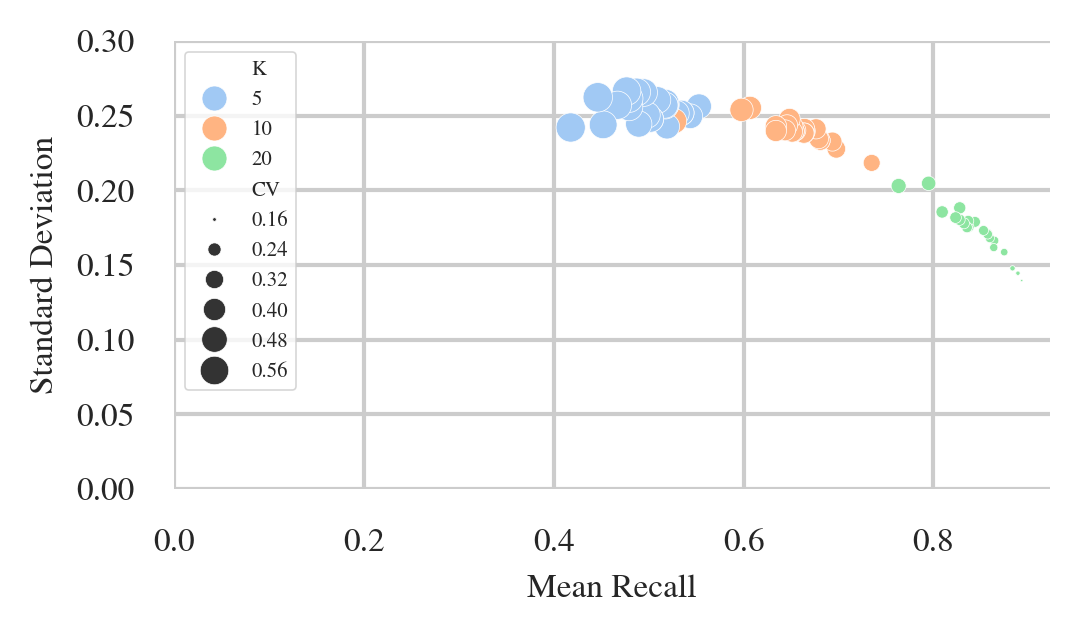

In [28]:
axis = initialize_plot(FIGSIZE_SINGLE)
stability["CV"] = stability["cv"]
sns.scatterplot(data=stability, x="mean", y="std", size="CV", sizes=(0, 50), hue=K, hue_order=KS, ax=axis)
plt.xlim(0)
plt.ylim(0, 0.3)
plt.xlabel("Mean Recall")
plt.ylabel("Standard Deviation")
sns.despine(left=True, bottom=True)
plt.savefig(os.path.join(RESULTS_DIRECTORY, f"stability_cv.pdf"), bbox_inches="tight", pad_inches=0)

In [29]:
k5 = dataframe[dataframe[K] == "5"]
k10 = dataframe[dataframe[K] == "10"]
k20 = dataframe[dataframe[K] == "20"]
k20

,Benchmark,Model,Chunking Strategy,Domain,K,Recall,Precision,Token
0,socbenchd_1,BGE,Endpoint Split (0),Energy,20,0.800000,0.200000,3047
1,socbenchd_1,BGE,Endpoint Split (0),Energy,20,0.800000,0.200000,3302
2,socbenchd_1,BGE,Endpoint Split (0),Energy,20,0.875000,0.350000,3474
3,socbenchd_1,BGE,Endpoint Split (0),Energy,20,0.666667,0.100000,3479
4,socbenchd_1,BGE,Endpoint Split (0),Energy,20,0.800000,0.200000,3249
...,...,...,...,...,...,...,...,...
545,socbenchd_5,OpenAI,CRAFT,Real Estate,20,1.000000,0.200000,3296
546,socbenchd_5,OpenAI,CRAFT,Real Estate,20,0.714286,0.250000,2993
547,socbenchd_5,OpenAI,CRAFT,Real Estate,20,0.500000,0.150000,3133
548,socbenchd_5,OpenAI,CRAFT,Real Estate,20,0.666667,0.100000,3116


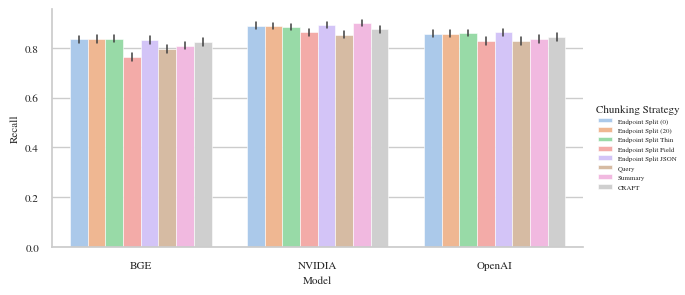

In [30]:
sns.catplot(x=MODEL, y=RECALL, hue=CHUNKING_STRATEGY, data=k20, kind="bar", height=3, aspect=2, errorbar=("ci", 95))

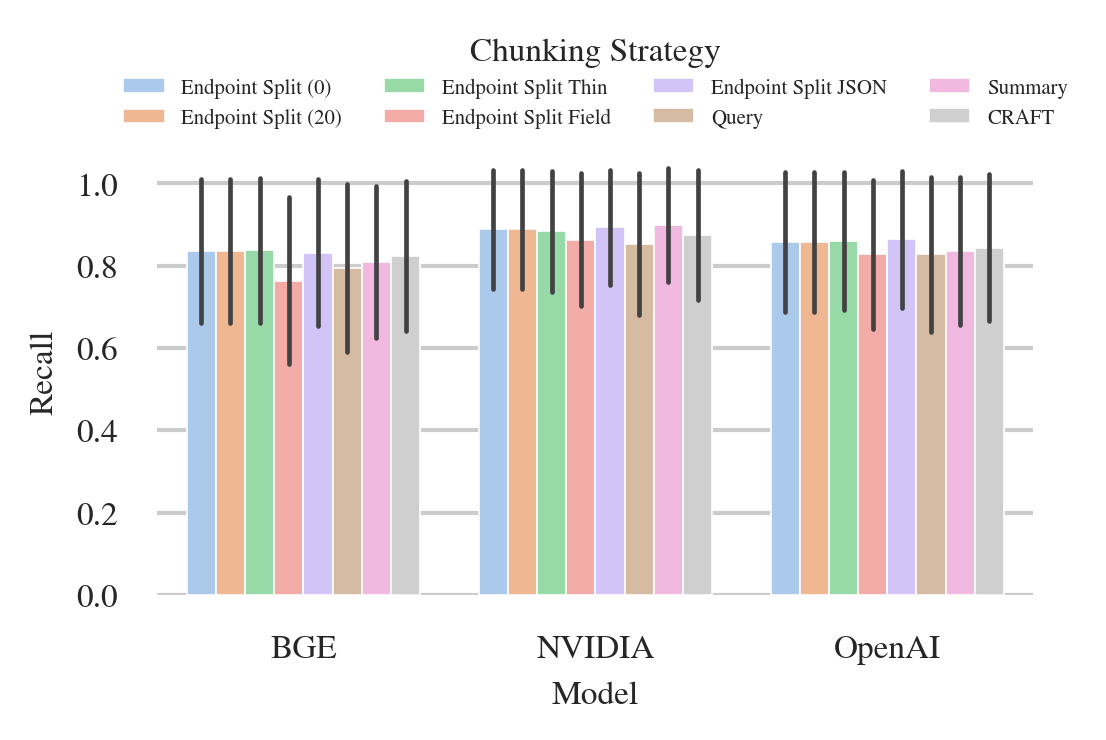

In [31]:
axis = initialize_plot(FIGSIZE_SINGLE)
sns.barplot(x=MODEL, y=RECALL, hue=CHUNKING_STRATEGY, data=k20, ax=axis, errorbar=("sd", 1))
sns.despine(left=True, bottom=True)
sns.move_legend(axis, "lower center", bbox_to_anchor=(0.5, 1), frameon=False, ncol=4)
plt.savefig(os.path.join(RESULTS_DIRECTORY, f"stability.pdf"), bbox_inches="tight", pad_inches=0)

In [32]:
domains = [
    "Communication Services",
    "Consumer Discretionary",
    "Consumer Staples",
    "Energy",
    "Financials",
    "Health Care",
    "Industrials",
    "Information Technology",
    "Materials",
    "Real Estate",
    "Utilities",
]
results = []
for k in KS:
    for model in MODELS_FORMATED:
        results_model = []
        for domain in domains:
            results_by_chunking_stategy = []
            for stategy in CHUNKING_STRATEGIES_FORMATED:
                filtered = dataframe[(dataframe[K] == k) & (dataframe[MODEL] == model) & (dataframe[CHUNKING_STRATEGY] == stategy) & (dataframe[DOMAIN] == domain)]
                results_by_chunking_stategy.append(filtered[RECALL].tolist())
            res = friedmanchisquare(*results_by_chunking_stategy)
            results_model.append(res.pvalue)
        results.append(results_model)

def format_pvalue(pvalue):
    if pvalue > 0.05:
        return f"\\textbf{{{pvalue:.2f}}}"
    return f"{pvalue:.2f}"
for i in range(len(domains)):
    line = f"{domains[i]}"
    for j in range(len(results)):
        line += f" & {format_pvalue(results[j][i])}"
    line += " \\\\"
    print(line)
print("\\hline")

results = []
for k in KS:
    for model in MODELS_FORMATED:
        results_by_chunking_stategy = []
        for stategy in CHUNKING_STRATEGIES_FORMATED:
            filtered = dataframe[(dataframe[K] == k) & (dataframe[MODEL] == model) & (dataframe[CHUNKING_STRATEGY] == stategy)]
            results_by_chunking_stategy.append(filtered[RECALL].tolist())
        res = friedmanchisquare(*results_by_chunking_stategy)
        results.append(format_pvalue(res.pvalue))
print("All & " + " & ".join(results))

Communication Services & 0.00 & 0.02 & 0.01 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 \\
Consumer Discretionary & \textbf{0.10} & 0.01 & 0.03 & 0.02 & 0.00 & \textbf{0.06} & 0.00 & \textbf{0.06} & \textbf{0.98} \\
Consumer Staples & 0.00 & \textbf{0.43} & \textbf{0.10} & 0.00 & 0.01 & 0.00 & \textbf{0.40} & 0.04 & \textbf{0.61} \\
Energy & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.01 & 0.00 & \textbf{0.06} & 0.01 \\
Financials & 0.00 & 0.00 & 0.03 & 0.02 & \textbf{0.12} & 0.01 & \textbf{0.06} & 0.00 & \textbf{0.73} \\
Health Care & \textbf{0.06} & 0.00 & \textbf{0.27} & 0.00 & 0.00 & 0.01 & 0.00 & 0.00 & 0.03 \\
Industrials & 0.00 & \textbf{0.35} & \textbf{0.24} & 0.00 & 0.00 & 0.00 & 0.00 & \textbf{0.30} & 0.01 \\
Information Technology & 0.01 & \textbf{0.54} & \textbf{0.27} & 0.00 & 0.00 & 0.00 & 0.00 & \textbf{0.31} & 0.00 \\
Materials & 0.00 & \textbf{0.50} & 0.01 & 0.00 & 0.00 & 0.03 & 0.05 & 0.00 & \textbf{0.21} \\
Real Estate & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 

In [33]:
results_by_chunking_stategy = []
for stategy in CHUNKING_STRATEGIES_FORMATED:
    filtered = dataframe[(dataframe[K] == "10") & (dataframe[CHUNKING_STRATEGY] == stategy) & (dataframe[MODEL] == "BGE")]
    results_by_chunking_stategy.append(filtered[RECALL].tolist())
print(len(results_by_chunking_stategy[0]))
res = friedmanchisquare(*results_by_chunking_stategy)
print(res.statistic, res.pvalue)

550
327.13259132862675 9.624241681575678e-67


In [34]:
results_by_chunking_stategy = []
for stategy in CHUNKING_STRATEGIES_FORMATED:
    filtered = dataframe[(dataframe[K] == "10") & (dataframe[CHUNKING_STRATEGY] == stategy) & (dataframe[MODEL] == "OpenAI")]
    results_by_chunking_stategy.append(filtered[RECALL].tolist())
print(len(results_by_chunking_stategy[0]))
res = friedmanchisquare(*results_by_chunking_stategy)
print(res.statistic, res.pvalue)

550
137.4634990560104 1.7272248219324094e-26


In [35]:
results_by_chunking_stategy = []
for stategy in CHUNKING_STRATEGIES_FORMATED:
    filtered = dataframe[(dataframe[K] == "10") & (dataframe[CHUNKING_STRATEGY] == stategy)]
    results_by_chunking_stategy.append(filtered[RECALL].tolist())
print(len(results_by_chunking_stategy[0]))
res = friedmanchisquare(*results_by_chunking_stategy)
print(res.statistic, res.pvalue)

1650
552.6712044983786 3.757692538824452e-115


## Whole Document and JSON Splitting Strategies
Non-endpoint split strategies

In [36]:
NON_ES_CHUNKING_STRATEGIES = [
    "whole_document_100_0",
    "whole_document_100_20",
    "whole_document_200_0",
    "whole_document_200_20",
    "json_100_0",
    "json_100_20",
]
NON_ES_CHUNKING_STRATEGIES_FORMATED = [rename_chunking_strategy(strategy) for strategy in NON_ES_CHUNKING_STRATEGIES]

In [37]:
non_es_results = [load_results(model, k, chunking_strategy) for model in MODELS for k in KS for chunking_strategy in NON_ES_CHUNKING_STRATEGIES]
non_es_dataframe = pd.concat(non_es_results)
non_es_dataframe

,Benchmark,Model,Chunking Strategy,Domain,K,Recall,Precision,Token
0,socbenchd_1,BGE,"Whole Document (100, 0)",Energy,5,0.000000,NaN,197
1,socbenchd_1,BGE,"Whole Document (100, 0)",Energy,5,0.200000,1.000000,191
2,socbenchd_1,BGE,"Whole Document (100, 0)",Energy,5,0.000000,NaN,119
3,socbenchd_1,BGE,"Whole Document (100, 0)",Energy,5,0.000000,NaN,134
4,socbenchd_1,BGE,"Whole Document (100, 0)",Energy,5,0.000000,NaN,197
...,...,...,...,...,...,...,...,...
545,socbenchd_5,OpenAI,"JSON (100, 20)",Real Estate,20,1.000000,0.210526,1989
546,socbenchd_5,OpenAI,"JSON (100, 20)",Real Estate,20,0.428571,0.230769,1927
547,socbenchd_5,OpenAI,"JSON (100, 20)",Real Estate,20,0.666667,0.200000,1927
548,socbenchd_5,OpenAI,"JSON (100, 20)",Real Estate,20,0.666667,0.076923,1991


In [38]:
non_es_grouped = non_es_dataframe.groupby([MODEL, CHUNKING_STRATEGY, K], as_index=False).mean(numeric_only=True)

<Axes: xlabel='Recall', ylabel='Precision'>

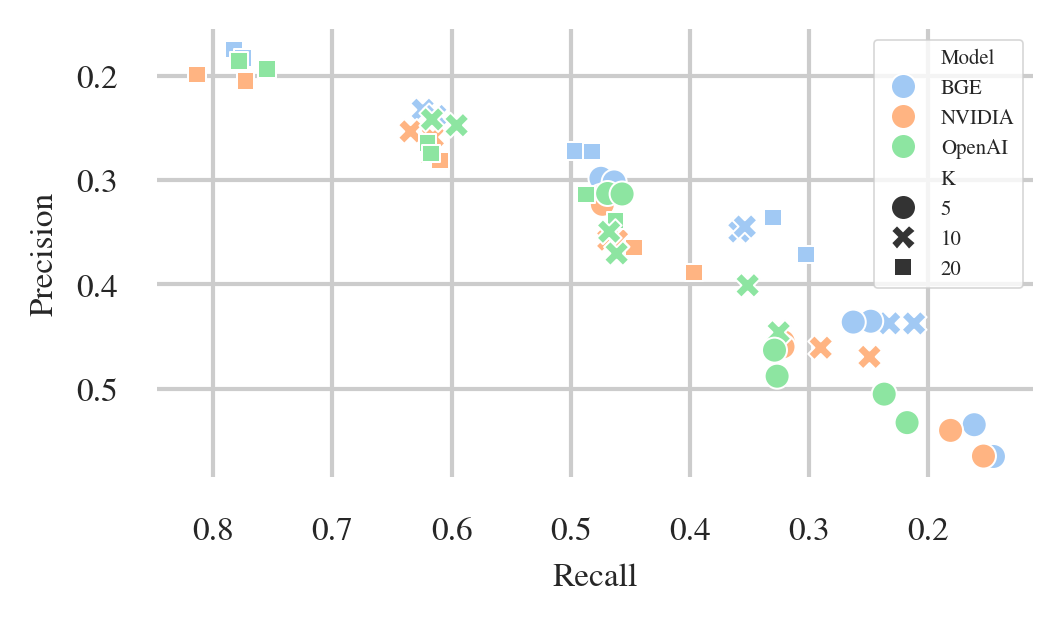

In [39]:
axis = initialize_plot(FIGSIZE_SINGLE)
axis.invert_xaxis()
axis.invert_yaxis()
sns.despine(left=True, bottom=True)
sns.scatterplot(x=RECALL, y=PRECISION, hue=MODEL, style=K, style_order=KS, data=non_es_grouped, ax=axis)

In [40]:
def non_es_legend(axis, split):
    handles, labels = axis.get_legend_handles_labels()
    chunking_strategy_handles = handles[:split]
    chunking_strategy_labels = labels[:split]
    k_handles = handles[split:]
    k_labels = labels[split:]
    legend_chunking_strategies = axis.legend(chunking_strategy_handles, chunking_strategy_labels, frameon=True, ncol=2)
    legend_k = axis.legend(k_handles, k_labels, frameon=True)
    axis.add_artist(legend_chunking_strategies)
    legend_chunking_strategies.set_bbox_to_anchor((0.4, 1))
    legend_chunking_strategies.set_loc("lower center")
    legend_k.set_bbox_to_anchor((0.85, 1))
    legend_k.set_loc("lower center")

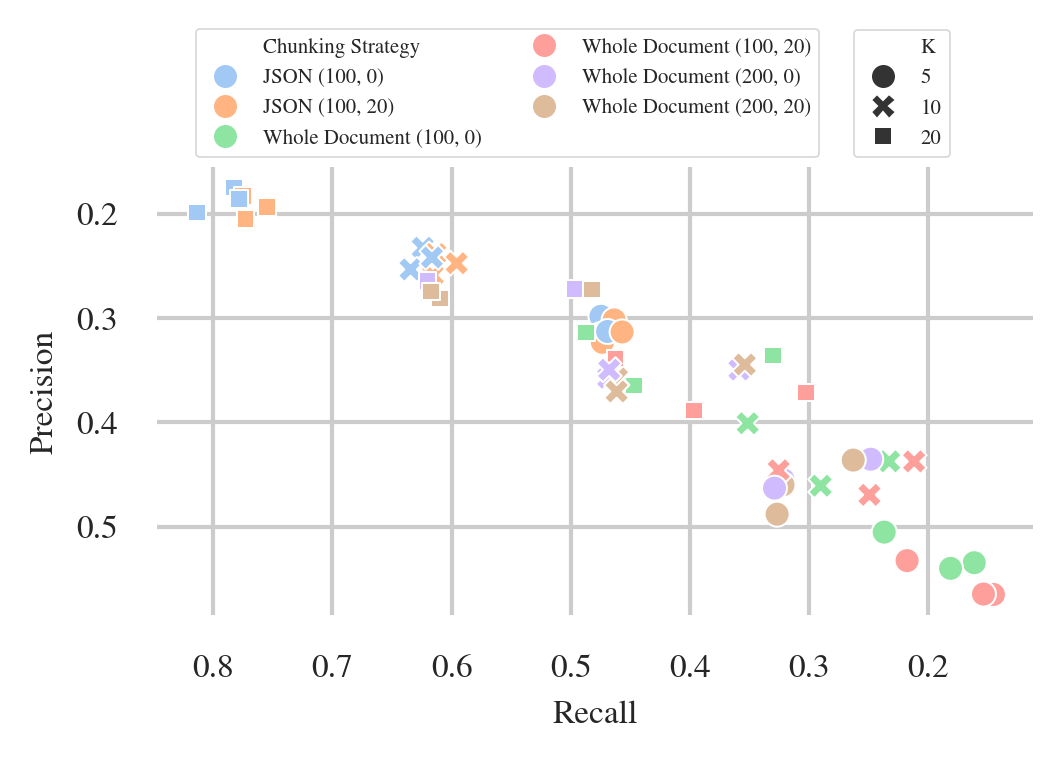

In [41]:
axis = initialize_plot(FIGSIZE_SINGLE)
axis.invert_xaxis()
axis.invert_yaxis()
sns.despine(left=True, bottom=True)
sns.scatterplot(x=RECALL, y=PRECISION, hue=CHUNKING_STRATEGY, style=K, style_order=KS, data=non_es_grouped, ax=axis)
split = len(NON_ES_CHUNKING_STRATEGIES) + 1
non_es_legend(axis, split)
plt.savefig(os.path.join(RESULTS_DIRECTORY, f"non_es.pdf"), bbox_inches="tight", pad_inches=0)

In [42]:
NV_JSON_WD_CHUNKING_STRATEGIES = [
    "whole_document_100_0",
    "whole_document_100_20",
    "whole_document_200_0",
    "whole_document_200_20",
    "json_100_0",
    "json_100_20",
    "summary"
]
NV_JSON_WD_CHUNKING_STRATEGIES_FORMATED = [rename_chunking_strategy(strategy) for strategy in NV_JSON_WD_CHUNKING_STRATEGIES]
nv_json_wd = [load_results(model, k, chunking_strategy) for model in MODELS for k in KS for chunking_strategy in NV_JSON_WD_CHUNKING_STRATEGIES]
nv_json_wd_dataframe = pd.concat(nv_json_wd)

In [43]:
nv_json_wd_dataframe_grouped = nv_json_wd_dataframe.groupby([MODEL, CHUNKING_STRATEGY, K], as_index=False).mean(numeric_only=True)

In [44]:
nv_json_wd_dataframe_grouped = nv_json_wd_dataframe_grouped[nv_json_wd_dataframe_grouped[MODEL] == "NVIDIA"]

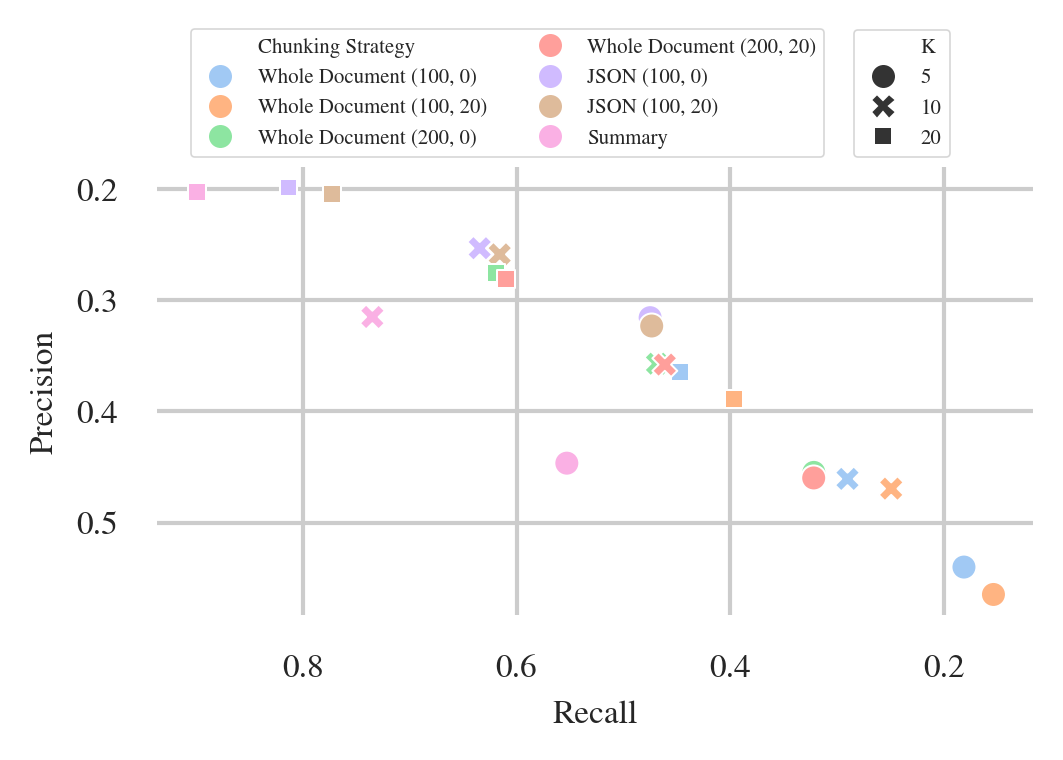

In [45]:
axis = initialize_plot(FIGSIZE_SINGLE)
axis.invert_xaxis()
axis.invert_yaxis()
sns.despine(left=True, bottom=True)
sns.scatterplot(x=RECALL, y=PRECISION, hue=CHUNKING_STRATEGY, hue_order=NV_JSON_WD_CHUNKING_STRATEGIES_FORMATED, style=K, style_order=KS, data=nv_json_wd_dataframe_grouped, ax=axis)
split = len(NV_JSON_WD_CHUNKING_STRATEGIES) + 1
non_es_legend(axis, split)
plt.savefig(os.path.join(RESULTS_DIRECTORY, f"non_es_summary.pdf"), bbox_inches="tight", pad_inches=0)

## Token Count

In [46]:
ALL_CHUNKING_STRATEGIES = [
    "whole_document_100_0",
    "whole_document_100_20",
    "whole_document_200_0",
    "whole_document_200_20",
    "json_100_0",
    "json_100_20",
    "endpoint_split_1024_0",
    "endpoint_split_1024_20",
    "endpoint_split_thin",
    "endpoint_split_field",
    "endpoint_json",
    "query_extraction",
    "summary",
    "craft",
]
ALL_CHUNKING_STRATEGIES_FORMATED = [rename_chunking_strategy(strategy) for strategy in ALL_CHUNKING_STRATEGIES]

In [47]:
all = [load_results(model, k, chunking_strategy) for model in MODELS for k in KS for chunking_strategy in ALL_CHUNKING_STRATEGIES]
all_dataframe = pd.concat(all)
all_dataframe_grouped = all_dataframe.groupby([MODEL, CHUNKING_STRATEGY, K], as_index=False).mean(numeric_only=True)
all_dataframe_grouped[K] = all_dataframe_grouped[K].astype(float)

In [48]:
all_dataframe_grouped["Token/Chunk"] = all_dataframe_grouped[TOKEN] / all_dataframe_grouped[K]

In [49]:
all_dataframe_grouped = all_dataframe_grouped.groupby([CHUNKING_STRATEGY], as_index=False).mean(numeric_only=True)

In [50]:
all_dataframe_grouped = all_dataframe_grouped.sort_values(by=["Token/Chunk"], ascending=True)

In [51]:
for row in all_dataframe_grouped.itertuples():
    line = f"{row[1]} & {row[6]:.2f} \\\\"
    print(line)

Whole Document (100, 0) & 34.93 \\
Whole Document (100, 20) & 35.16 \\
Whole Document (200, 20) & 56.87 \\
Whole Document (200, 0) & 56.96 \\
JSON (100, 0) & 97.46 \\
JSON (100, 20) & 97.76 \\
Endpoint Split Thin & 121.94 \\
Endpoint Split JSON & 131.85 \\
Endpoint Split Field & 152.33 \\
Endpoint Split (0) & 155.31 \\
Endpoint Split (20) & 155.32 \\
Query & 155.70 \\
CRAFT & 157.41 \\
Summary & 161.29 \\


## Agent

In [52]:
AGENT = [
    "agent",
    "summary"
]
AGENT_FORMATED = [rename_chunking_strategy(strategy) for strategy in AGENT]
agent = [load_results("oai", k, "agent", precise_token=True) for k in ["20", "100"]] + [load_results("oai", k, "summary") for k in KS]
agent_dataframe = pd.concat(agent)
agent_dataframe[K] = agent_dataframe[K].replace("100", "all")
agent_dataframe_grouped = agent_dataframe.groupby([MODEL, CHUNKING_STRATEGY, K], as_index=False).mean(numeric_only=True)

In [53]:
agent_dataframe

,Benchmark,Model,Chunking Strategy,Domain,K,Recall,Precision,Token Completion,Token Prompt,Token Response,Token
0,socbenchd_1,OpenAI,Agent,Energy,20,0.400000,0.400000,418.0,2563.0,33.0,NaN
1,socbenchd_1,OpenAI,Agent,Energy,20,0.800000,1.000000,611.0,9785.0,26.0,NaN
2,socbenchd_1,OpenAI,Agent,Energy,20,0.500000,0.500000,482.0,2643.0,50.0,NaN
3,socbenchd_1,OpenAI,Agent,Energy,20,1.000000,0.600000,308.0,2303.0,33.0,NaN
4,socbenchd_1,OpenAI,Agent,Energy,20,0.600000,1.000000,346.0,2497.0,29.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
545,socbenchd_5,OpenAI,Summary,Real Estate,20,1.000000,0.210526,NaN,NaN,NaN,3395.0
546,socbenchd_5,OpenAI,Summary,Real Estate,20,0.857143,0.300000,NaN,NaN,NaN,3222.0
547,socbenchd_5,OpenAI,Summary,Real Estate,20,0.500000,0.150000,NaN,NaN,NaN,3262.0
548,socbenchd_5,OpenAI,Summary,Real Estate,20,0.333333,0.050000,NaN,NaN,NaN,3249.0


In [54]:
agent_dataframe_grouped

,Model,Chunking Strategy,K,Recall,Precision,Token Completion,Token Prompt,Token Response,Token
0,OpenAI,Agent,20,0.708698,0.759831,371.716364,2721.934545,28.700000,NaN
1,OpenAI,Agent,all,0.867378,0.850523,375.601818,5385.352727,30.425455,NaN
2,OpenAI,Summary,10,0.664109,0.280940,NaN,NaN,NaN,1561.474545
3,OpenAI,Summary,20,0.836668,0.185513,NaN,NaN,NaN,3092.003636
4,OpenAI,Summary,5,0.509121,0.406485,NaN,NaN,NaN,787.287273


In [55]:
agent_dataframe_grouped.loc[agent_dataframe_grouped[CHUNKING_STRATEGY] == "Summary", "Token Response"] = agent_dataframe_grouped[agent_dataframe_grouped[CHUNKING_STRATEGY] == "Summary"]["Token"]
agent_dataframe_grouped

,Model,Chunking Strategy,K,Recall,Precision,Token Completion,Token Prompt,Token Response,Token
0,OpenAI,Agent,20,0.708698,0.759831,371.716364,2721.934545,28.700000,NaN
1,OpenAI,Agent,all,0.867378,0.850523,375.601818,5385.352727,30.425455,NaN
2,OpenAI,Summary,10,0.664109,0.280940,NaN,NaN,1561.474545,1561.474545
3,OpenAI,Summary,20,0.836668,0.185513,NaN,NaN,3092.003636,3092.003636
4,OpenAI,Summary,5,0.509121,0.406485,NaN,NaN,787.287273,787.287273


### Pareto Front Analysis

<Axes: xlabel='Chunking Strategy', ylabel='Recall'>

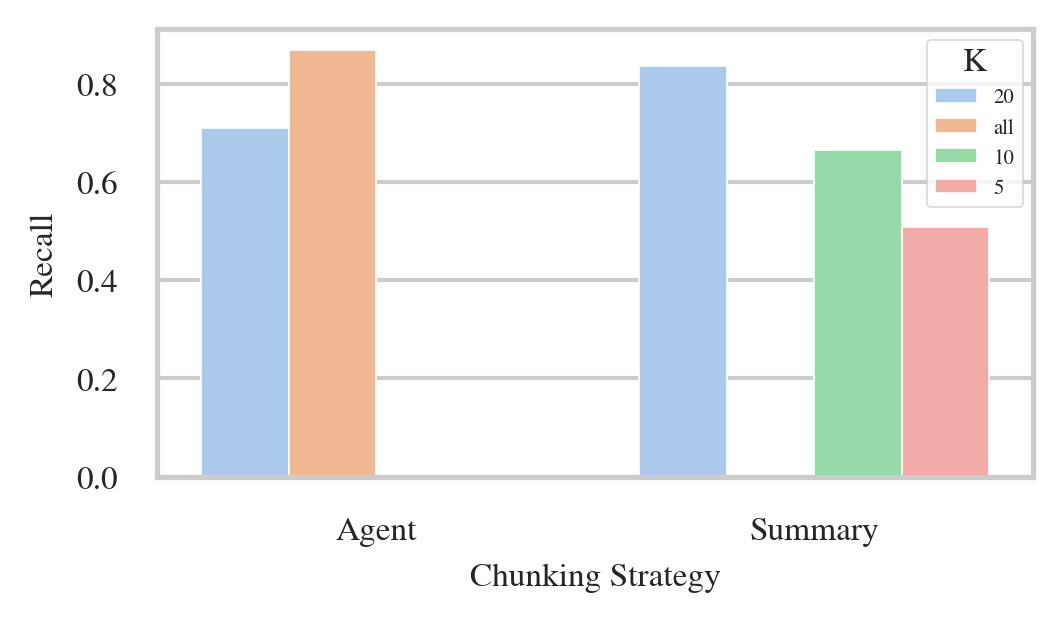

In [56]:
axis = initialize_plot(FIGSIZE_SINGLE)
sns.barplot(data=agent_dataframe_grouped, x=CHUNKING_STRATEGY, y=RECALL, hue=K, ax=axis)

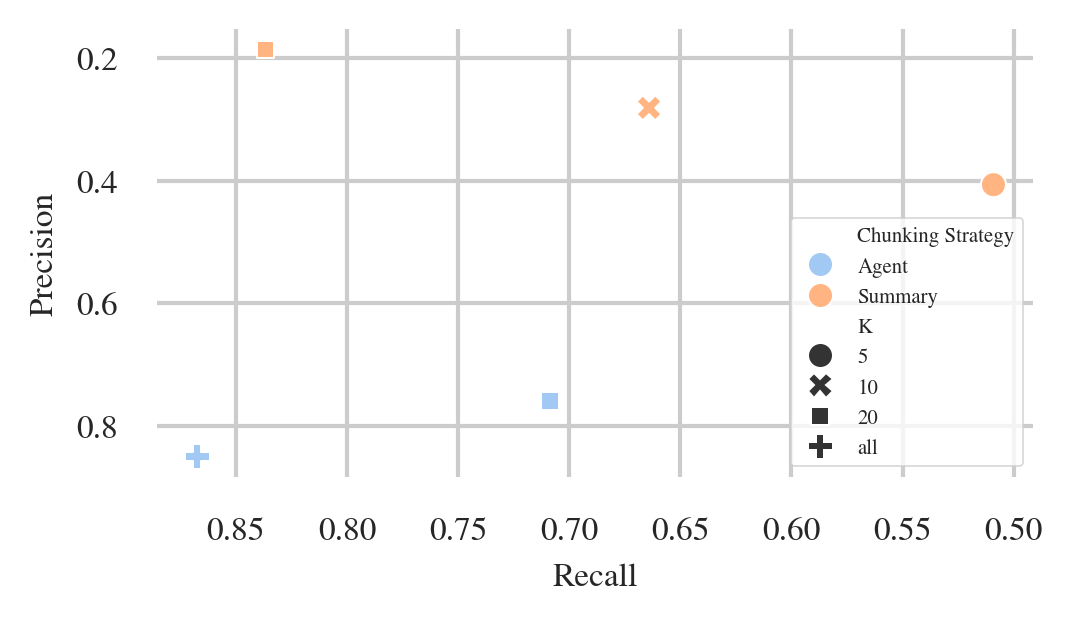

In [57]:
axis = initialize_plot(FIGSIZE_SINGLE)
axis.invert_xaxis()
axis.invert_yaxis()
sns.despine(left=True, bottom=True)
sns.scatterplot(data=agent_dataframe_grouped, x=RECALL, y=PRECISION, hue=CHUNKING_STRATEGY, style=K, style_order=["5", "10", "20", "all"], ax=axis)
plt.savefig(os.path.join(RESULTS_DIRECTORY, "pareto_agent.pdf"), bbox_inches="tight", pad_inches=0)

# RestBench

In [58]:
def load_restbench_results(model: str, k: str, chunking_strategy: str, precise_token: bool = False) -> DataFrame:
    result_files = [open(f'../data/restbench/{model}/{chunking_strategy}/results_{k}.json').read()]
    results = BenchmarkResultSet(name="restbench", results=[BenchmarkResult.model_validate_json(result_file) for result_file in result_files])
    return merge_benchmark_results([results], chunking_strategy, model, k, precise_token)
restbench_results = [load_restbench_results(model, k, chunking_strategy) for model in MODELS for k in KS for chunking_strategy in CHUNKING_STRATEGIES]
restbench_dataframe = pd.concat(restbench_results)

In [59]:
restbench_dataframe

,Benchmark,Model,Chunking Strategy,Domain,K,Recall,Precision,Token
0,restbench,BGE,Endpoint Split (0),Restbench,5,0.250000,0.20,2561
1,restbench,BGE,Endpoint Split (0),Restbench,5,0.333333,0.20,2345
2,restbench,BGE,Endpoint Split (0),Restbench,5,0.666667,0.50,1938
3,restbench,BGE,Endpoint Split (0),Restbench,5,0.500000,0.20,1907
4,restbench,BGE,Endpoint Split (0),Restbench,5,0.000000,0.00,2001
...,...,...,...,...,...,...,...,...
152,restbench,OpenAI,CRAFT,Restbench,20,1.000000,0.10,79362
153,restbench,OpenAI,CRAFT,Restbench,20,1.000000,0.10,115619
154,restbench,OpenAI,CRAFT,Restbench,20,1.000000,0.20,114057
155,restbench,OpenAI,CRAFT,Restbench,20,0.500000,0.05,102240


In [60]:
restbench_grouped = restbench_dataframe.groupby([MODEL, CHUNKING_STRATEGY, K], as_index=False).mean(numeric_only=True)
restbench_grouped

,Model,Chunking Strategy,K,Recall,Precision,Token
0,BGE,CRAFT,10,0.696921,0.157325,27583.305732
1,BGE,CRAFT,20,0.843418,0.097452,55543.547771
2,BGE,CRAFT,5,0.524947,0.229299,13446.076433
3,BGE,Endpoint Split (0),10,0.507962,0.159258,7166.407643
4,BGE,Endpoint Split (0),20,0.637473,0.120189,14561.388535
5,BGE,Endpoint Split (0),5,0.375265,0.203079,3541.082803
6,BGE,Endpoint Split (20),10,0.527070,0.165446,7237.554140
7,BGE,Endpoint Split (20),20,0.621550,0.116144,14583.726115
8,BGE,Endpoint Split (20),5,0.389066,0.212845,3574.350318
9,BGE,Endpoint Split Field,10,0.586518,0.134395,27995.108280


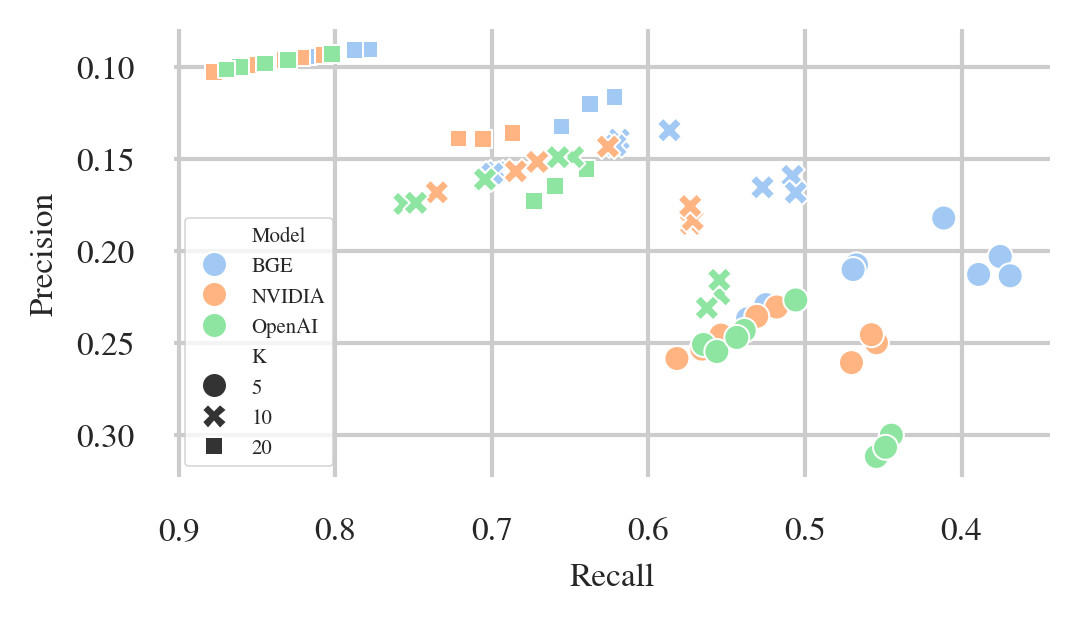

In [61]:
axis = initialize_plot(FIGSIZE_SINGLE)
axis.invert_xaxis()
axis.invert_yaxis()
sns.despine(left=True, bottom=True)
sns.scatterplot(x=RECALL, y=PRECISION, hue=MODEL, style=K, style_order=KS, data=restbench_grouped, ax=axis)
plt.savefig(os.path.join(RESULTS_DIRECTORY, f"restbench_cross-domain_average.pdf"), bbox_inches="tight", pad_inches=0)

In [62]:
COUNT = 10
precision = restbench_grouped.sort_values(by=[PRECISION], ascending=False).head(COUNT)
recall = restbench_grouped.sort_values(by=[RECALL], ascending=False).head(COUNT)
index = 1

for (row_precision, row_recall) in zip(precision.itertuples(), recall.itertuples()):
    line = f"{index}. & {row_recall[1]} & {row_recall[2]} & {row_recall[3]} & {row_precision[1]} & {row_precision[2]} & {row_precision[3]} \\\\"
    line = line.replace("Endpoint Split", "ES")
    line = line.replace("NVIDIA", "NV")
    line = line.replace("OpenAI", "OAI")
    print(line)
    index += 1

1. & NV & ES Thin & 20 & OAI & ES (20) & 5 \\
2. & OAI & Summary & 20 & OAI & ES JSON & 5 \\
3. & OAI & ES Thin & 20 & OAI & ES (0) & 5 \\
4. & NV & Summary & 20 & NV & ES (20) & 5 \\
5. & OAI & CRAFT & 20 & NV & ES Thin & 5 \\
6. & BGE & CRAFT & 20 & OAI & ES Thin & 5 \\
7. & NV & CRAFT & 20 & NV & Summary & 5 \\
8. & OAI & Query & 20 & OAI & CRAFT & 5 \\
9. & NV & Query & 20 & NV & ES (0) & 5 \\
10. & BGE & Summary & 20 & OAI & Summary & 5 \\


In [63]:
restbench_stability = restbench_dataframe.groupby(by=[MODEL,CHUNKING_STRATEGY,K])[RECALL].agg(["mean", "std", cv])
restbench_stability = restbench_stability.sort_values(by="mean", ascending=False)
restbench_stability.reset_index()

,Model,Chunking Strategy,K,mean,std,cv
0,NVIDIA,Endpoint Split Thin,20,0.877389,0.219175,0.249804
1,OpenAI,Summary,20,0.869427,0.216665,0.249205
2,OpenAI,Endpoint Split Thin,20,0.860934,0.217099,0.252167
3,NVIDIA,Summary,20,0.853503,0.231587,0.271337
4,OpenAI,CRAFT,20,0.845011,0.230828,0.273166
5,BGE,CRAFT,20,0.843418,0.220752,0.261735
6,NVIDIA,CRAFT,20,0.832272,0.236454,0.284107
7,OpenAI,Query,20,0.830149,0.226236,0.272525
8,NVIDIA,Query,20,0.821656,0.232174,0.282568
9,BGE,Summary,20,0.817410,0.237046,0.289996


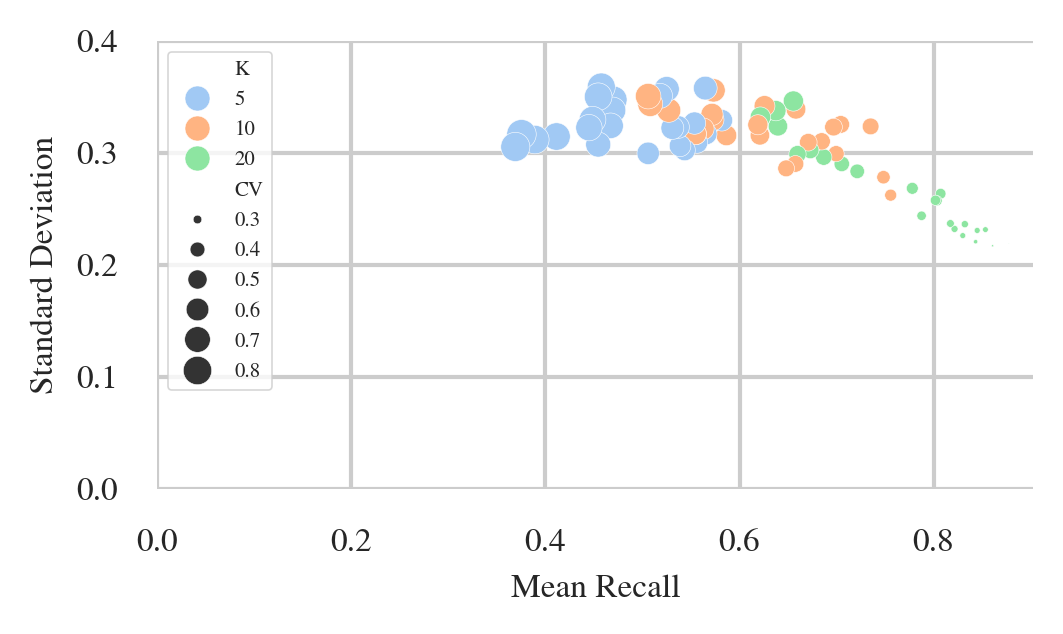

In [64]:
axis = initialize_plot(FIGSIZE_SINGLE)
restbench_stability["CV"] = restbench_stability["cv"]
sns.scatterplot(data=restbench_stability, x="mean", y="std", size="CV", sizes=(0, 50), hue=K, hue_order=KS, ax=axis)
plt.xlim(0)
plt.ylim(0, 0.4)
plt.xlabel("Mean Recall")
plt.ylabel("Standard Deviation")
sns.despine(left=True, bottom=True)
plt.savefig(os.path.join(RESULTS_DIRECTORY, f"restbench_stability_cv.pdf"), bbox_inches="tight", pad_inches=0)

In [65]:
results = []
for k in KS:
    for model in MODELS_FORMATED:
        results_by_chunking_stategy = []
        for stategy in CHUNKING_STRATEGIES_FORMATED:
            filtered = restbench_dataframe[(restbench_dataframe[K] == k) & (restbench_dataframe[MODEL] == model) & (restbench_dataframe[CHUNKING_STRATEGY] == stategy)]
            results_by_chunking_stategy.append(filtered[RECALL].tolist())
        res = friedmanchisquare(*results_by_chunking_stategy)
        results.append(format_pvalue(res.pvalue))
print("All & " + " & ".join(results))

All & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00


## Whole Document and JSON Splitting Strategies

In [66]:
restbench_non_es_results = [load_restbench_results(model, k, chunking_strategy) for model in MODELS for k in KS for chunking_strategy in NON_ES_CHUNKING_STRATEGIES]
restbench_non_es_dataframe = pd.concat(restbench_non_es_results)
restbench_non_es_dataframe

,Benchmark,Model,Chunking Strategy,Domain,K,Recall,Precision,Token
0,restbench,BGE,"Whole Document (100, 0)",Restbench,5,0.0,NaN,212
1,restbench,BGE,"Whole Document (100, 0)",Restbench,5,0.0,NaN,203
2,restbench,BGE,"Whole Document (100, 0)",Restbench,5,0.0,NaN,177
3,restbench,BGE,"Whole Document (100, 0)",Restbench,5,0.0,0.000000,329
4,restbench,BGE,"Whole Document (100, 0)",Restbench,5,0.0,0.000000,241
...,...,...,...,...,...,...,...,...
152,restbench,OpenAI,"JSON (100, 20)",Restbench,20,0.5,0.250000,1946
153,restbench,OpenAI,"JSON (100, 20)",Restbench,20,0.0,0.000000,1892
154,restbench,OpenAI,"JSON (100, 20)",Restbench,20,0.0,0.000000,1901
155,restbench,OpenAI,"JSON (100, 20)",Restbench,20,1.0,0.200000,1923


In [67]:
restbench_non_es_grouped = restbench_non_es_dataframe.groupby([MODEL, CHUNKING_STRATEGY, K], as_index=False).mean(numeric_only=True)
restbench_non_es_grouped.sort_values(by=[RECALL], ascending=False)

,Model,Chunking Strategy,K,Recall,Precision,Token
4,BGE,"JSON (100, 20)",20,0.668790,0.149194,1881.490446
19,NVIDIA,"JSON (100, 0)",20,0.652335,0.248961,1892.815287
22,NVIDIA,"JSON (100, 20)",20,0.641720,0.249570,1869.165605
37,OpenAI,"JSON (100, 0)",20,0.634289,0.212402,1898.579618
1,BGE,"JSON (100, 0)",20,0.625265,0.134412,1894.331210
40,OpenAI,"JSON (100, 20)",20,0.617834,0.221536,1866.757962
21,NVIDIA,"JSON (100, 20)",10,0.565287,0.291750,932.757962
18,NVIDIA,"JSON (100, 0)",10,0.556794,0.290594,944.840764
3,BGE,"JSON (100, 20)",10,0.551486,0.169330,945.662420
36,OpenAI,"JSON (100, 0)",10,0.547240,0.243923,951.171975


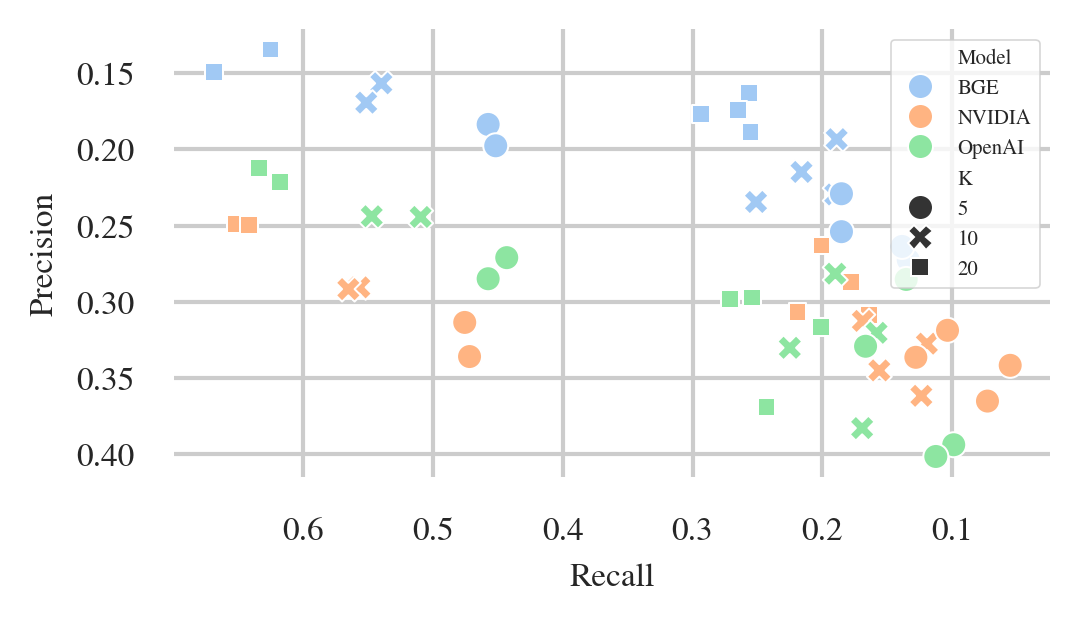

In [68]:
axis = initialize_plot(FIGSIZE_SINGLE)
axis.invert_xaxis()
axis.invert_yaxis()
sns.despine(left=True, bottom=True)
sns.scatterplot(x=RECALL, y=PRECISION, hue=MODEL, style=K, style_order=KS, data=restbench_non_es_grouped, ax=axis)
sns.move_legend(axis, "upper right")
plt.savefig(os.path.join(RESULTS_DIRECTORY, f"restbench_non_es_model.pdf"), bbox_inches="tight", pad_inches=0)

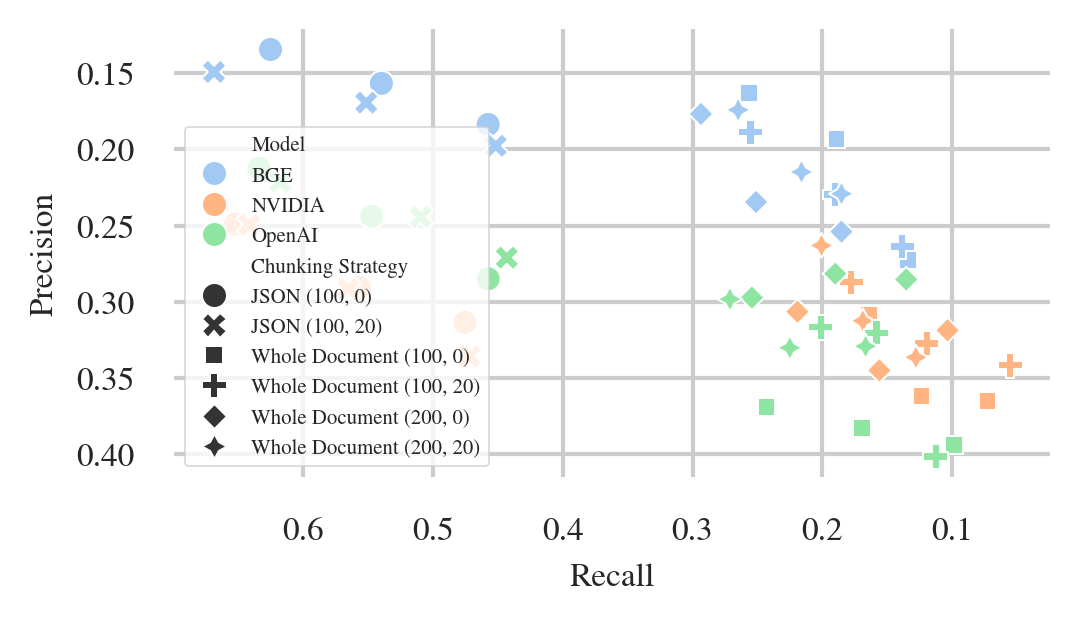

In [69]:
axis = initialize_plot(FIGSIZE_SINGLE)
axis.invert_xaxis()
axis.invert_yaxis()
sns.despine(left=True, bottom=True)
sns.scatterplot(x=RECALL, y=PRECISION, hue=MODEL, style=CHUNKING_STRATEGY, data=restbench_non_es_grouped, ax=axis)
sns.move_legend(axis, "lower left")

In [70]:
restbench_nv_json_wd = [load_restbench_results(model, k, chunking_strategy) for model in MODELS for k in KS for chunking_strategy in NV_JSON_WD_CHUNKING_STRATEGIES]
restbench_nv_json_wd_dataframe = pd.concat(restbench_nv_json_wd)
restbench_nv_json_wd_dataframe_grouped = restbench_nv_json_wd_dataframe.groupby([MODEL, CHUNKING_STRATEGY, K], as_index=False).mean(numeric_only=True)
restbench_nv_json_wd_dataframe_grouped = restbench_nv_json_wd_dataframe_grouped[restbench_nv_json_wd_dataframe_grouped[MODEL] == "NVIDIA"]

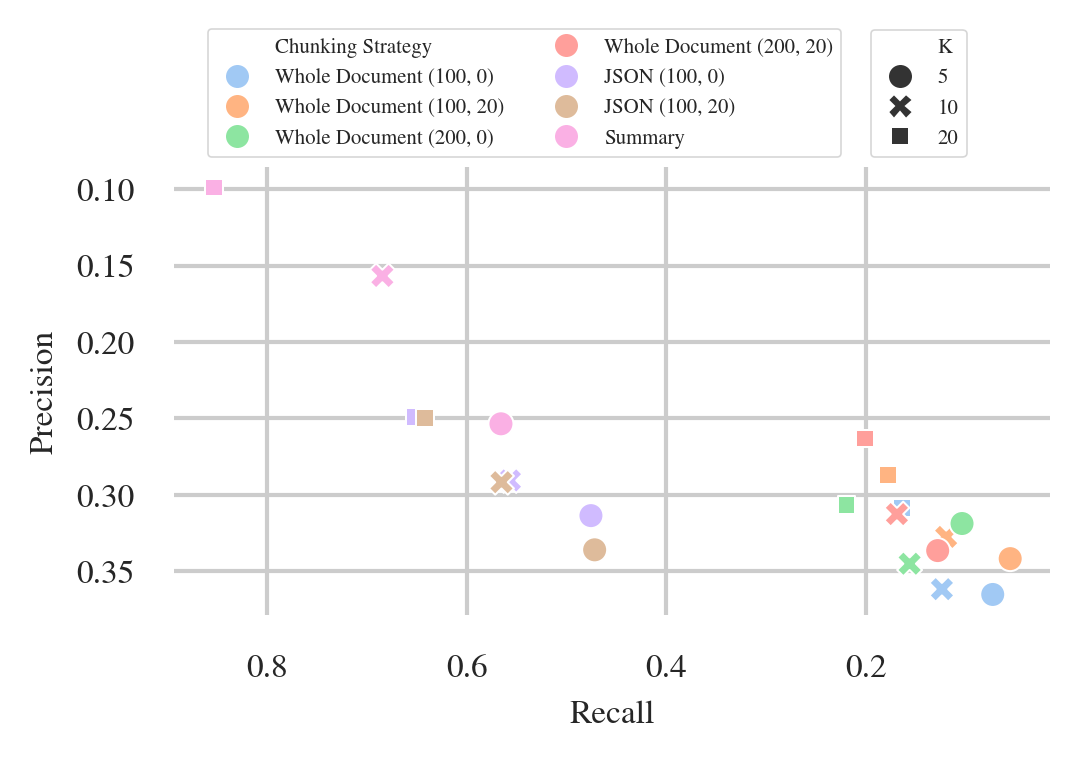

In [71]:
axis = initialize_plot(FIGSIZE_SINGLE)
axis.invert_xaxis()
axis.invert_yaxis()
sns.despine(left=True, bottom=True)
sns.scatterplot(x=RECALL, y=PRECISION, hue=CHUNKING_STRATEGY, hue_order=NV_JSON_WD_CHUNKING_STRATEGIES_FORMATED, style=K, style_order=KS, data=restbench_nv_json_wd_dataframe_grouped, ax=axis)
split = len(NV_JSON_WD_CHUNKING_STRATEGIES) + 1
non_es_legend(axis, split)
plt.savefig(os.path.join(RESULTS_DIRECTORY, f"restbench_non_es_summary.pdf"), bbox_inches="tight", pad_inches=0)

## RestBench Agent

In [72]:
restbench_agent = [load_restbench_results("oai", k, "agent", precise_token=True) for k in ["20", "100"]] + [load_restbench_results("oai", k, "summary") for k in KS]
restbench_agent_dataframe = pd.concat(restbench_agent)
restbench_agent_dataframe[K] = restbench_agent_dataframe[K].replace("100", "all")
restbench_agent_dataframe_grouped = restbench_agent_dataframe.groupby([MODEL, CHUNKING_STRATEGY, K], as_index=False).mean(numeric_only=True)

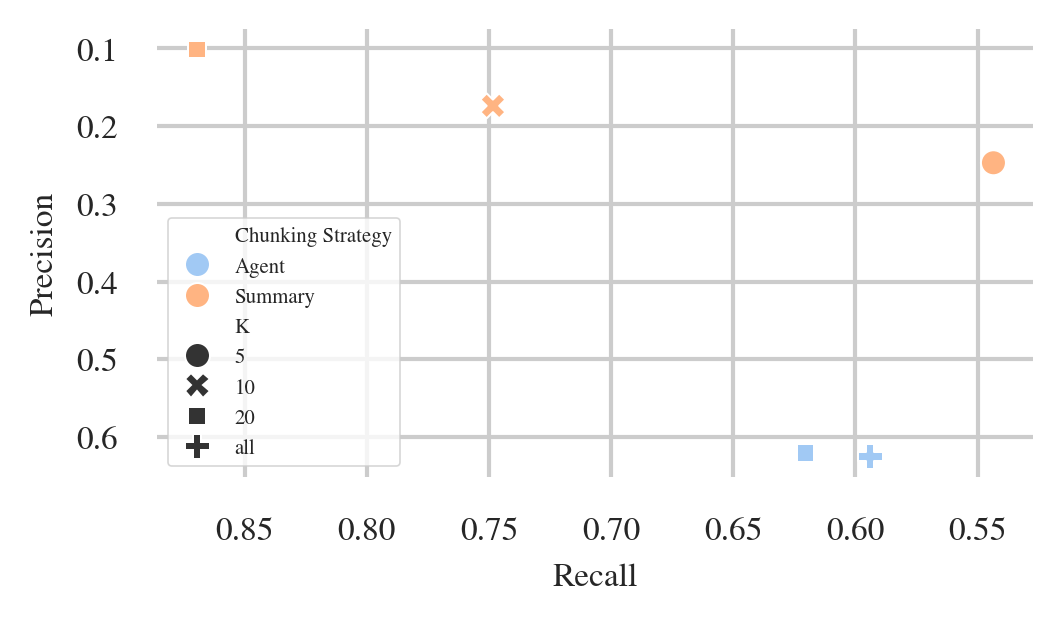

In [73]:
axis = initialize_plot(FIGSIZE_SINGLE)
axis.invert_xaxis()
axis.invert_yaxis()
sns.despine(left=True, bottom=True)
sns.scatterplot(data=restbench_agent_dataframe_grouped, x=RECALL, y=PRECISION, hue=CHUNKING_STRATEGY, style=K, style_order=["5", "10", "20", "all"], ax=axis)
plt.savefig(os.path.join(RESULTS_DIRECTORY, "restbench_pareto_agent.pdf"), bbox_inches="tight", pad_inches=0)